**The purpose of this notebook is to check for linear correlations between the experimental dG from the affinity benchmark
and other calculated quantities, such as BPMF, minimum interaction energy, mean interaction energy, etc.**

In [198]:
import os
import pickle

# Define the directory paths
bpmf_dir = '/mnt/fft/FFT_PPI/2.redock/6.postprocess/'
fft_sample_dir = '/mnt/fft/FFT_PPI/2.redock/5.fft_sampling/'
affinity_bm_file = '/mnt/fft/FFT_PPI/1.data_prep/1.affinity_database/affinity_bm.p'

# Initialize the systems list and systems_dict dictionary
bad_systems = ["2HQS_A:H", "3A4S_A:D", "3K75_D:B", "4IZ7_A:B", "1A2K_C:AB", "1AHW_AB:C", "1AKJ_AB:DE", "1BJ1_HL:VW", "1BVK_DE:F", "1CBW_ABC:D", "1DE4_AB:CF", "1DQJ_AB:C", "1E4K_AB:C", "1E6J_HL:P", "1EER_A:BC", "1EZU_C:AB", "1FSK_BC:A", "1HCF_AB:X", "1HIA_AB:I", "1I4D_D:AB", "1IB1_AB:E", "1IJK_A:BC", "1IQD_AB:C", "1JMO_A:HL", "1JPS_HL:T", "1JWH_CD:A", "1K5D_AB:C", "1KKL_ABC:H", "1KLU_AB:D", "1M27_AB:C", "1MLC_AB:E", "1NB5_AP:I", "1NCA_HL:N", "1NSN_HL:S", "1P2C_AB:C", "1RLB_ABCD:E", "1RV6_VW:X", "1VFB_AB:C", "1WDW_BD:A", "1WEJ_HL:F", "1XU1_ABD:T", "2B4J_AB:C", "2JEL_HL:P", "2MTA_HL:A", "2NYZ_AB:D", "2OOR_AB:C", "2VIR_AB:C", "2VIS_AB:C", "2VXT_HL:I", "2W9E_HL:A", "3AAA_AB:C", "3BP8_AB:C", "3EOA_LH:I", "3G6D_LH:A", "3HI6_XY:B", "3L5W_LH:I", "3L89_ABC:M", "3LVK_AC:B", "3MXW_LH:A", "3R9A_AC:B", "3RVW_CD:A", "3SZK_DE:F", "3V6Z_AB:F", "4DN4_LH:M", "4FQI_HL:ABEFCD", "4G6J_HL:A", "4G6M_HL:A", "4GXU_MN:ABEFCD", "4HX3_BD:A"] 
bad_systems = []
systems = []
systems_dict = {}

# Function to get all files with a specific name in a directory
def get_files_in_directory(directory, file_name):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename == file_name:
                if os.path.basename(os.path.join(root, filename)) not in bad_systems:
                    files.append(os.path.join(root, filename))
    return files

# Find all bpmf.pkl files and create the systems list
bpmf_files = get_files_in_directory(bpmf_dir, 'bpmf.pkl')
systems = [os.path.dirname(file) for file in bpmf_files if os.path.basename(file) not in bad_systems]
systems.sort()  # Sort the systems list alphabetically

# Find all fft_sample.nc files and populate the systems_dict dictionary
for system in systems:
    if os.path.basename(system) not in bad_systems:
        bpmf_path = os.path.join(system, 'bpmf.pkl')
        fft_sample_path = os.path.join(fft_sample_dir, os.path.basename(system), 'fft_sample.nc')
        systems_dict[os.path.basename(system)] = {
            'bpmf_path': bpmf_path,
            'fft_sample_path': fft_sample_path
        }

# Load the additional affinity_bm.p file
with open(affinity_bm_file, 'rb') as affinity_file:
    affinity_data = pickle.load(affinity_file)

for system in bad_systems:
    del affinity_data[system]

# Load and combine all bpmf.pkl files for each system into a larger dictionary
bpmf_combined_dict = {}
for system, paths in systems_dict.items():
    with open(paths['bpmf_path'], 'rb') as bpmf_file:
        bpmf_data = pickle.load(bpmf_file)
    bpmf_combined_dict[system] = bpmf_data

# Extract 'dG' and 'Kd' values from the affinity data for each system
dG_and_Kd_values = {}
for system, data in affinity_data.items():
    dG_and_Kd_values[os.path.basename(system)] = {
        'dG': data['dG'],
        'Kd': data['Kd']
    }


In [199]:
# Initialize a dictionary to store the combined values
combined_bpmf_data = {}

# Iterate through the dictionaries in the list
for _, data in bpmf_combined_dict.items():
    for key, subdict in data.items():
        if key not in combined_bpmf_data:
            combined_bpmf_data[key] = {}
        for sub_key, value in subdict.items():
            if sub_key not in combined_bpmf_data[key]:
                combined_bpmf_data[key][sub_key] = []
            combined_bpmf_data[key][sub_key].append(value)

combined_affinity_data = {}

for _, data in affinity_data.items():
    for key, value in data.items():
        if key not in combined_affinity_data:
            combined_affinity_data[key] = []
        combined_affinity_data[key].append(value)

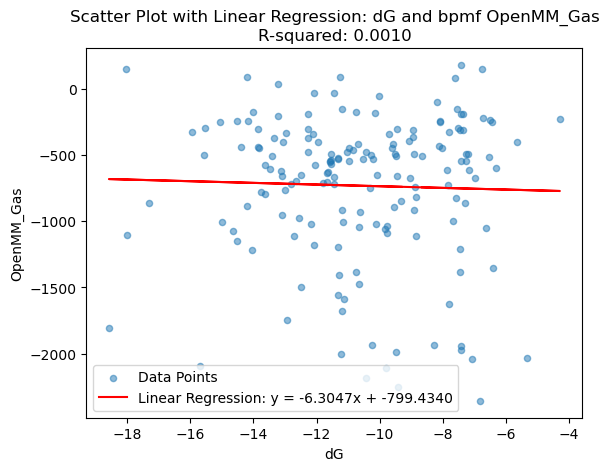

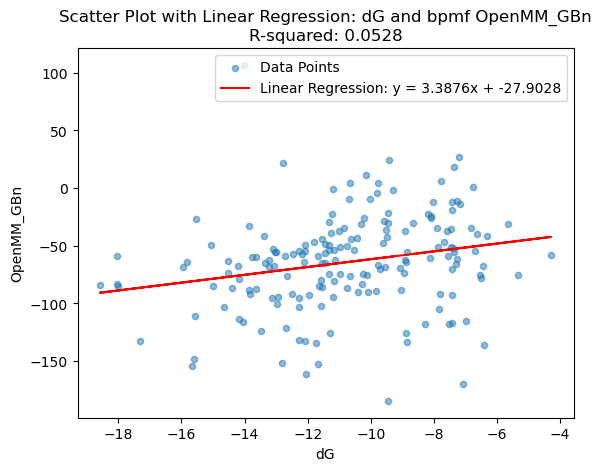

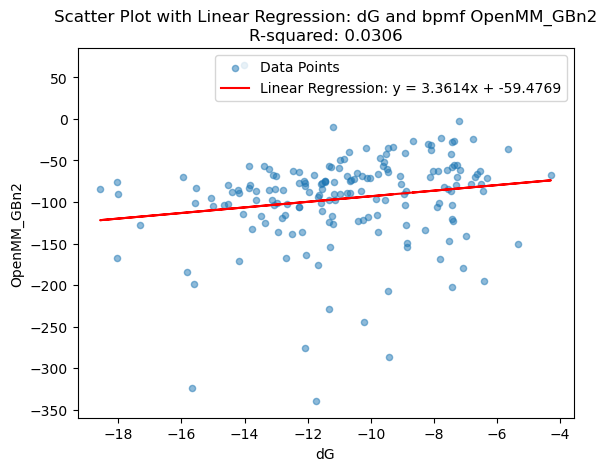

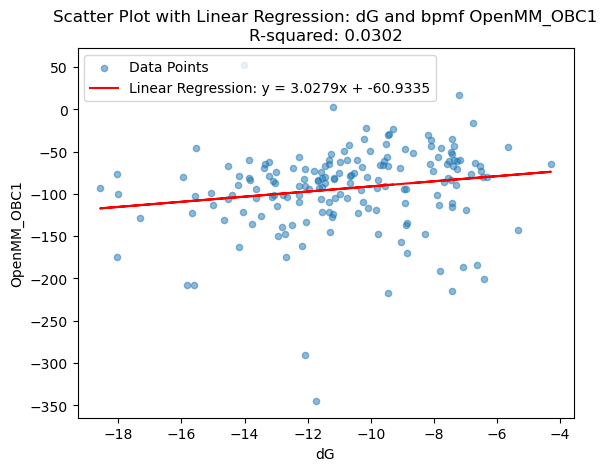

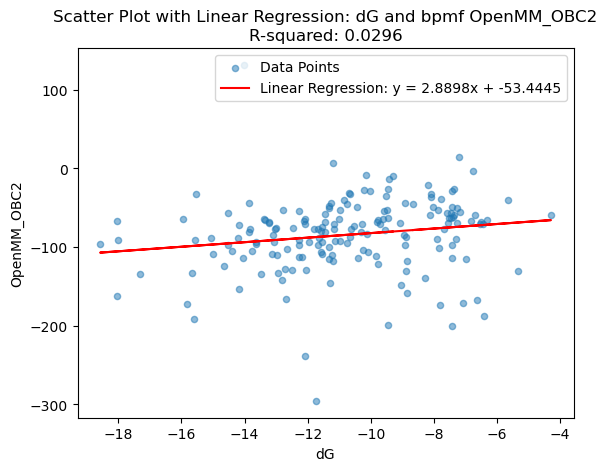

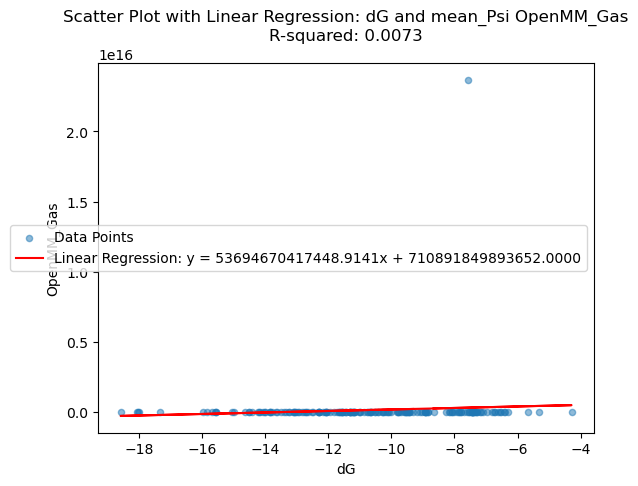

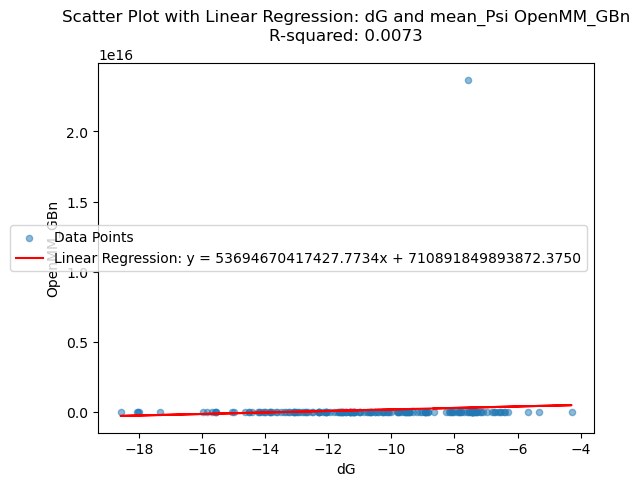

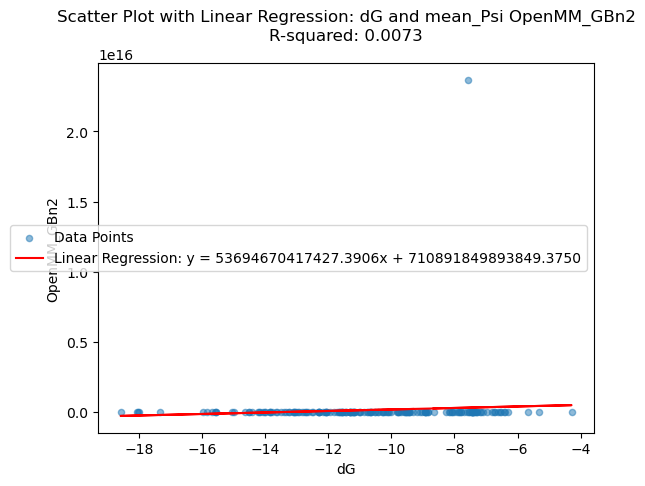

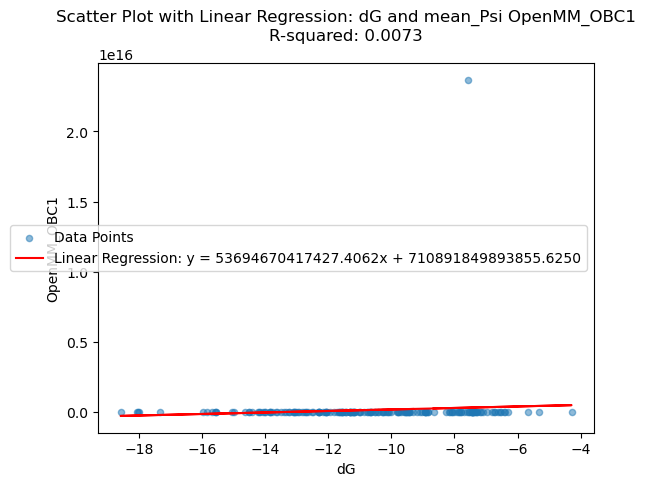

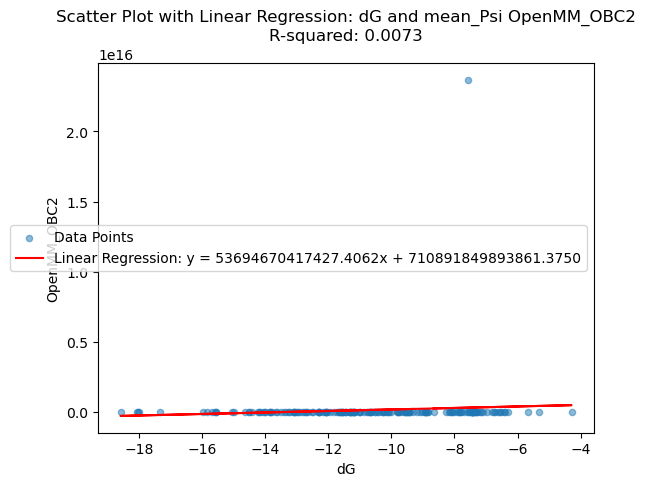

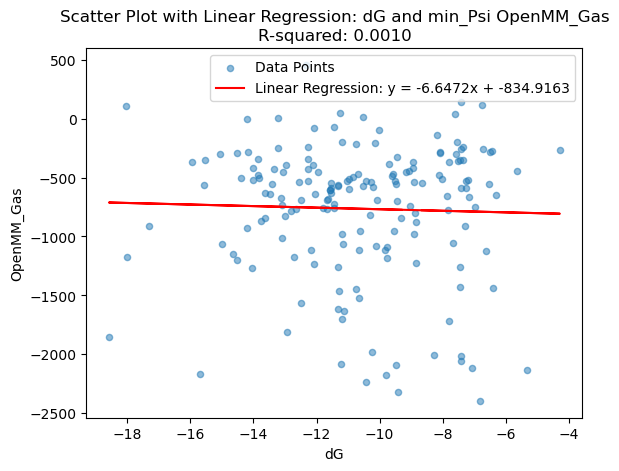

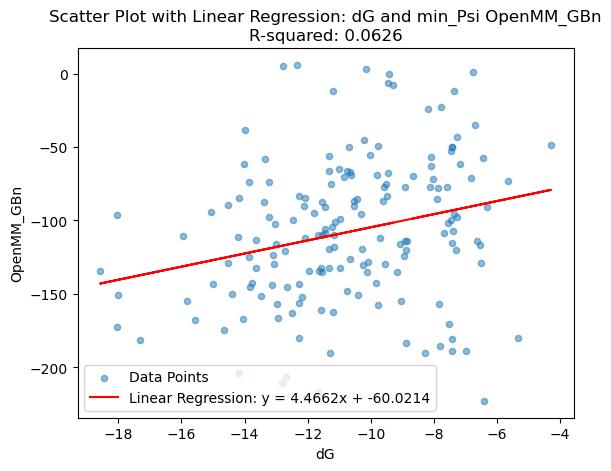

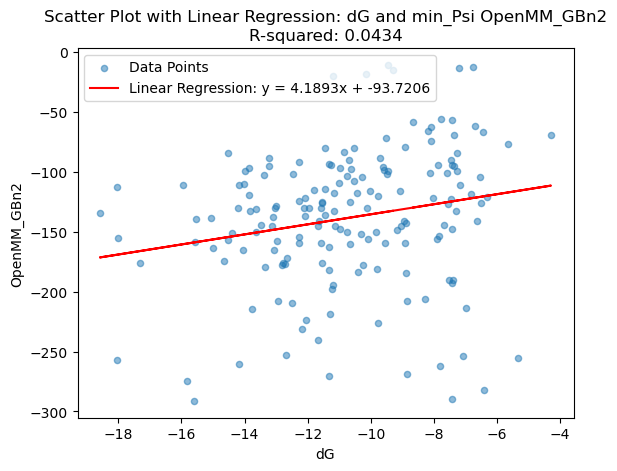

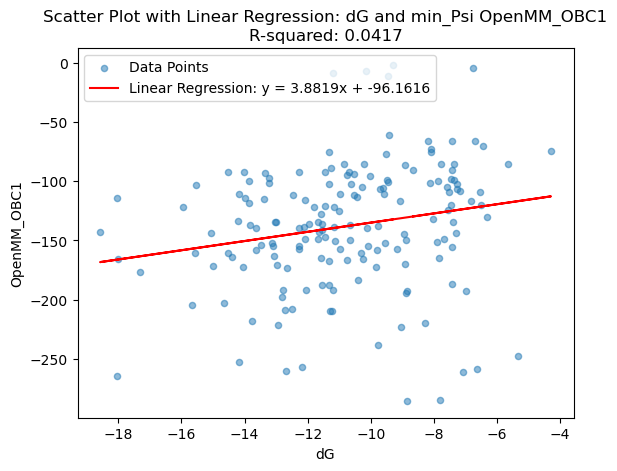

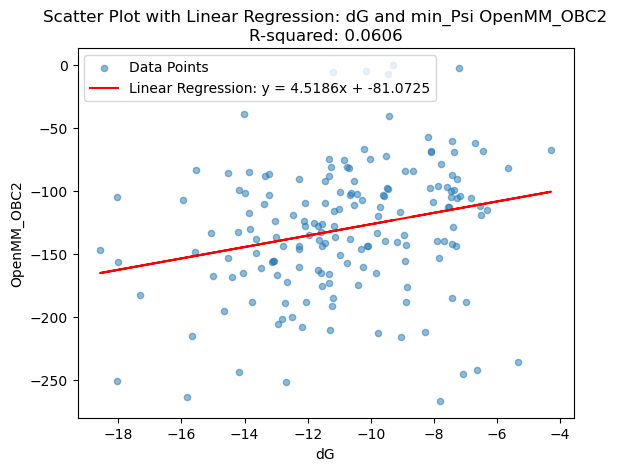

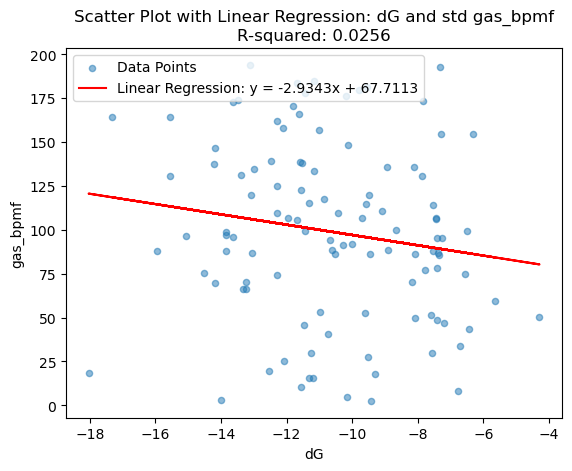

ValueError: could not convert string to float: '<1.4e-11'

In [200]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

for key_i, x in combined_affinity_data.items():
    for key_j, data_type in combined_bpmf_data.items():
        for key_k, y in data_type.items():
            x = np.array(x, dtype=np.float64)
            if type(y[0]) == dict:
                pass
            else:
                y = np.array(y, dtype=np.float64)
                y[y == np.inf] = np.nan
                y[y == -np.inf] = np.nan
                y_mean = np.nanmean(y)
                y_std = np.nanstd(y)
                too_high = y_mean + 2 * y_std
                too_low = y_mean - 2 * y_std
                a = (y > too_low)
                b = (y < too_high)
                c = (y != 0)
                filter = (a & b & c)
                f_y = y[filter]
                f_x = x[filter]

                # Calculate the linear regression parameters
                slope, intercept, r_value, p_value, std_err = linregress(f_x, f_y)

                # Create the scatter plot
                plt.figure()
                # plt.scatter(f_x, f_y, s=20, alpha=0.5, label='Data Points')
                plt.scatter(f_x, f_y, s=20, alpha=0.5, label='Data Points')
                
                # Calculate the R-squared value
                r_squared = r_value**2
                
                # Include R-squared value in the title
                title = f'Scatter Plot with Linear Regression: {key_i} and {key_j} {key_k}\nR-squared: {r_squared:.4f}'
                plt.title(title)
                plt.xlabel(key_i)
                plt.ylabel(key_k)

                # Plot the linear regression line and include the equation in the legend
                regression_label = f'Linear Regression: y = {slope:.4f}x + {intercept:.4f}'
                plt.plot(f_x, slope * f_x + intercept, color='red', label=regression_label)

                # Add a legend
                plt.legend()

                plt.show()


In [192]:
import netCDF4 as nc
nc_file = nc.Dataset(systems_dict['2OOB_A:B']['fft_sample_path'], 'r')
resampled_energies = nc_file.variables["resampled_energies"][:]

In [196]:
import numpy as np


# Sample Psi values (replace this with your data)
psi_values = resampled_energies.flatten()

print(len(psi_values))
# Number of bootstrap samples
num_samples = 50

# Number of data points in each sample (can be the same as the original data)
sample_size = len(psi_values)

# Initialize an array to store bootstrap sample means
bootstrap_averages = np.zeros(num_samples)

# Perform bootstrapping
for i in range(num_samples):
    # Generate a random sample with replacement
    bootstrap_sample = np.random.choice(psi_values, size=sample_size, replace=True)
    
    original_equation_values = -1/0.001987204134799235/300 * np.log(np.exp(-0.001987204134799235 * 300 * bootstrap_sample))
    
    # Calculate the average of the original equation values for this bootstrap sample
    bootstrap_averages[i] = np.mean(original_equation_values)

# Calculate the mean and standard error of the bootstrap sample means
bootstrap_mean = np.mean(bootstrap_means)
bootstrap_std_error = np.std(bootstrap_means)

print(f"Original Mean of Psi: {np.mean(psi_values):.2f}")
print(f"Bootstrap Mean: {bootstrap_mean:.10f}")
print(f"Bootstrap Standard Error: {bootstrap_std_error:.2f}")


1200000
Original Mean of Psi: -87.97
Bootstrap Mean: 0.0000000000
Bootstrap Standard Error: 0.00
